# Importing packages¶

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import random
import geopy.distance

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("cbc") or os.path.isfile("cbc")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq coinor-cbc
    else:
        try:
            !conda install -c conda-forge coincbc 
        except:
            pass

assert(shutil.which("cbc") or os.path.isfile("cbc"))
from pyomo.environ import *
import pyomo.environ as pyo
import pyomo.gdp as gdp

     |████████████████████████████████| 9.5MB 5.4MB/s 
     |████████████████████████████████| 256kB 44.5MB/s 
     |████████████████████████████████| 51kB 6.5MB/s 
     |████████████████████████████████| 163kB 55.1MB/s 
Selecting previously unselected package coinor-libcoinutils3v5.
(Reading database ... 160706 files and directories currently installed.)
Preparing to unpack .../0-coinor-libcoinutils3v5_2.10.14+repack1-1_amd64.deb ...
Unpacking coinor-libcoinutils3v5 (2.10.14+repack1-1) ...
Selecting previously unselected package coinor-libosi1v5.
Preparing to unpack .../1-coinor-libosi1v5_0.107.9+repack1-1_amd64.deb ...
Unpacking coinor-libosi1v5 (0.107.9+repack1-1) ...
Selecting previously unselected package coinor-libclp1.
Preparing to unpack .../2-coinor-libclp1_1.16.11+repack1-1_amd64.deb ...
Unpacking coinor-libclp1 (1.16.11+repack1-1) ...
Selecting previously unselected package coinor-libcgl1.
Preparing to unpack .../3-coinor-libcgl1_0.59.10+repack1-1_amd64.deb ...
Unpacking coi

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
###########
from scipy.stats.stats import pearsonr  
x1 = [5.0,4.5,4.0,4.0,2.0,4.0,4.5,4.5,5.0,3.0,4.0,4.0,4.5,4.0,2.0,4.5,4.5,4.5,5.0,2.0]
x2 = [2.0,4.0,4.0,4.5,2.5,2.5,4.0,4.5,5.0,2.5,2.5,4.5,4.0,4.0,2.0,3.5,4.5,4.5,4.5,3.5]
x3 = [4.0,4.0,4.0,4.5,3.0,4.5,3.5,5.0,5.0,4.0,3.5,4.0,4.5,3.5,3.5,4.0,4.5,5.0,4.0,3.0]
x4 = [2.5,4.5,4.5,5.0,1.0,3.0,4.5,5.0,5.0,2.0,1.5,4.5,4.5,4.5,1.5,2.0,5.0,5.0,4.5,2.5]

print(sum(x1))
print(sum(x2))
print(sum(x3))
print(sum(x4))

import scipy
import scipy.stats
from scipy.stats import pearsonr

corr, p_value = pearsonr(x1, x3)
print(corr,'  ',p_value)




79.5
73.0
81.0
72.5
0.6552309317192664    0.0017136365407111485


## function 

In [97]:
#########################################
#     Matrix Completion     #
#########################################
class MF():

    def __init__(self, R, K, gamma, beta, iterations):
        self.R = R          #input matrix
        self.rows = len(self.R ) 
        self.columns = len(self.R[0] )#self.num_users, self.num_items = R.shape
        self.K = K          #number of latent dimensions
        self.gamma = gamma  #learning rate
        self.beta = beta    #regularization parameter
        self.iterations = iterations

    def train(self):
        # Initialize user and item latent feature matrice
        self.P = np.random.normal(scale=1./(self.K*10), size=(self.rows, self.K))#np.full((self.num_users, self.K),0.05)#np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./(self.K*10), size=(self.columns, self.K))#np.full((self.num_items, self.K),-0.05)#np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initialize the biases
        self.b_u = np.zeros(self.rows)
        self.b_i = np.zeros(self.columns)
        self.b = np.mean(self.R[np.where(self.R != 0)])

        # Create a list of training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.rows)
            for j in range(self.columns)
            if self.R[i, j] > 0
        ]

        # Perform stochastic gradient descent for number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))

        return training_process

    def mse(self):
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error = pow(self.R[x, y] - predicted[x, y], 2) + error
        return np.sqrt(error)

    def sgd(self):
        for i, j, r_ij in self.samples:
            # Computer prediction and error
            r_ij_next = self.get_rating(i, j)
            delta_r = (r_ij - r_ij_next)

            # Update biases
            self.b_u[i] = self.b_u[i] + self.gamma * 2 * (delta_r -  self.beta * self.b_u[i])
            self.b_i[j] = self.b_i[j] + self.gamma * 2 * (delta_r - self.beta * self.b_i[j])

            # Update user and item latent feature matrices
            self.P[i, :] = self.P[i, :] + self.gamma * 2 * (delta_r * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] = self.Q[j, :] + self.gamma * 2 * (delta_r * self.P[i, :] - self.beta * self.Q[j,:])

    def get_rating(self, i, j):
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    def full_matrix(self):
        return self.b + self.b_u[:,np.newaxis] + self.b_i[np.newaxis:,] + self.P.dot(self.Q.T)

In [67]:
class P_INDIVIDUAL():

    def  __init__(self, UserID, LocaLa, LocaLo, DistI, MBudgI):
        self.UserID = UserID
        self.LocaI = (LocaLa,LocaLo)
        self.DistI = DistI
        self.MBudgI = MBudgI
        self.MRateI = pd.DataFrame(columns = ['name','RatingI'])
        self.Lextra = np.array([])

    def UpdateMRateI(self, TargetStore, RateStore):
        self.MRateI = self.MRateI.append(TargetStore)
        self.MRateI['RatingI'].iloc[[-1]] = RateStore

    def InputExtraRestrict(self,inputarray):
        self.Lextra = inputarray

    def ShowIndInfo(self):
        print("ID :",self.UserID,"  location :",self.LocaI,"  tolerant dist:",self.DistI,"  tolerant budget:",self.MBudgI,"  accept cuisine:",self.Lextra)
        print(self.MRateI)

In [68]:
class P_ENVIRONMENT():

    def __init__(self, MData):
        self.NPLocaI = np.array([])
        self.NPDistI = np.array([])
        self.NPBudgI = np.array([])
        self.MData = MData
        self.NPRate = np.array([])
        self.NPMPrice = np.array([])
        self.NPCuisine = np.array([])

    def SetNPLocaI(self,LocaI,IntUserID):
        UserIDStr = 'DistUser' + str(IntUserID)
        tempdistdf = pd.DataFrame()
        partdistdf = self.MData[['latitude','longitude']].copy().fillna(0)
        tempdistdf[UserIDStr] = partdistdf.apply(lambda x: geopy.distance.vincenty(LocaI, (x['latitude'], x['longitude'])).mi, axis = 1)
        #print(tempdistdf)
        tempdistnp = tempdistdf.transpose().to_numpy()
        #print(tempdistnp)
        self.NPLocaI = np.vstack((self.NPLocaI,tempdistnp )) if self.NPLocaI.size else tempdistnp
        #self.NPLocaI = np.append(self.NPLocaI,tempdistdf.to_numpy())
    
    def SetNPDistI(self,DistI):
        self.NPDistI = np.append(self.NPDistI,DistI)

    def SetNPBudgI(self,BudgI):
        self.NPBudgI = np.vstack((self.NPBudgI,BudgI )) if self.NPBudgI.size else BudgI#np.append(self.NPBudgI,[BudgI])

    def SetNPCuisine(self,CuisineI):
        self.NPCuisine = np.vstack((self.NPCuisine,CuisineI )) if self.NPCuisine.size else CuisineI

    def AddRatingCol(self,TargetMatrix,IntUserID,BoolFirst):
        UserIDStr = 'user' + str(IntUserID)
        TargetMatrix.rename(columns={'RatingI':UserIDStr}, inplace=True)
        if UserIDStr in self.MData.columns:
            self.MData.update(TargetMatrix[UserIDStr])
            #self.MData = self.MData.combine_first(TargetMatrix)
        else:
            self.MData = pd.concat([self.MData, TargetMatrix[UserIDStr]], axis=1)
    
    def SetNPRate(self,ifactor,gammai=0.1,betai=0.01,iiterations=100):
        tempcol = [x for x in self.MData.columns if 'user' in x]#################
        tempmf = MF(np.array(self.MData[tempcol].fillna(0)) , K=ifactor, gamma=gammai, beta=betai, iterations=iiterations)
        training_process = tempmf.train()
        self.NPRate = tempmf.full_matrix()
        return training_process

    def SetNPMPrice(self):
        self.NPMPrice = np.array(self.MData['dollars_price'].map({'<30':30,'31-50':50,'50+':150}).astype(int))

    def ShowEnvSetting(self):
        print("matrix of distance person to store :",self.NPLocaI)
        print("matrix of tolerant distance-person :",self.NPDistI)
        print("matrix of tolerant budget-person   :",self.NPBudgI)
        print("matrix of acceptable cuisine   :",self.NPCuisine)
        print("dataset head 10:",self.MData.head(10))

In [69]:
def ChooseSampleStore(BoolRand, OriginalSet, TargetCol, TargetStr, SortCol, k_store, start_number):
    tempdf = OriginalSet[OriginalSet[TargetCol] == TargetStr].sort_values(SortCol, ascending = False)
    if BoolRand:
        return tempdf.iloc[ random.sample(range(start_number,len(tempdf)),k_store)  ]
    else:
        return  tempdf.iloc[list(range(start_number,start_number+k_store))]

In [70]:
def InputStoreRate(PersonObj, Targetdf, Ratenp):
    for i in range(len(Ratenp)):
        PersonObj.UpdateMRateI(pd.DataFrame(Targetdf.iloc[[i]]),Ratenp[i])

In [71]:
#########################################
#     Optimation Model      #
#########################################
class Opt_model():

    def __init__(self,Case_Obj):
        self.testcase = Case_Obj
        self.Lextra = pd.DataFrame()
        

    def CuisineRestric(self):
        self.Lextra = self.testcase.MData[['cuisine']]
        cuisine_freq = self.Lextra['cuisine'].value_counts()
        less_cuisine = cuisine_freq[cuisine_freq<cuisine_freq[8]]
        self.Lextra.loc[ self.Lextra['cuisine'].isin(less_cuisine.index.to_list()) ] = 'other'
        self.Lextra = pd.get_dummies(self.Lextra)

    def FindRestaurant(self, alpha): # give the function the previous assignments
        Npeople = len(self.testcase.NPBudgI)
        Ntime = len(self.testcase.NPBudgI[0])
        Nres = len(self.testcase.NPMPrice)
        Mdist = self.testcase.NPLocaI.transpose()
        Mrate = self.testcase.NPRate.transpose()
        Mprice = self.testcase.NPMPrice
        Rdist = self.testcase.NPDistI
        Rprice = self.testcase.NPBudgI
        #alpha = self.alpha

        m = pyo.ConcreteModel() 

        m.K = pyo.Set(initialize=range(Nres))
        m.T = pyo.Set(initialize=range(Ntime))
        m.I = pyo.Set(initialize=range(Npeople))
    
        # Decision variables
        m.x = pyo.Var(m.T,m.K, domain = Binary) # Decision Variable describing whether a banking branch is put in county
      
        # objective function
        m.coverage = pyo.Objective(expr = sum( Mrate[i,k] * m.x[t,k] - alpha * Mdist[k,i] * m.x[t,k] for i in m.I for k in m.K for t in m.T ), sense=pyo.maximize )

        # Constraints
        m.timesrestrict = ConstraintList()
        for t in m.T:
            m.timesrestrict.add(sum(m.x[t,k] for k in m.K ) == 1)
    
        m.noduplicate = ConstraintList()
        for k in m.K:
            m.noduplicate.add(sum(m.x[t,k] for t in m.T ) <= 1)

        m.distancecons = ConstraintList()
        for t in m.T:
            for i in m.I:
                m.distancecons.add(sum(m.x[t,k] * Mdist[k,i] for k in m.K ) <= Rdist[i] )

        m.budgetcons = ConstraintList()
        for i in m.I:
            for t in m.T:
                m.budgetcons.add(sum( m.x[t,k] * Mprice[k] for k in m.K ) <= Rprice[i,t] ) 

        #self.modelR = m
        return m

    def FindRestaurant_v2(self, alpha): # give the function the previous assignments
        Npeople = len(self.testcase.NPBudgI)
        Ntime = len(self.testcase.NPBudgI[0])
        Nres = len(self.testcase.NPMPrice)
        Nextra = len(self.Lextra.columns)
        Mdist = self.testcase.NPLocaI.transpose()
        Mrate = self.testcase.NPRate.transpose()
        Mprice = self.testcase.NPMPrice
        Rdist = self.testcase.NPDistI
        Rprice = self.testcase.NPBudgI
        Mextra = np.array(self.Lextra) 
        #alpha = self.alpha

        m = pyo.ConcreteModel() 

        m.K = pyo.Set(initialize=range(Nres))
        m.T = pyo.Set(initialize=range(Ntime))
        m.I = pyo.Set(initialize=range(Npeople))
        m.E = pyo.Set(initialize=range(Nextra))
    
        # Decision variables
        m.x = pyo.Var(m.T,m.K, domain = Binary) # Decision Variable describing whether a banking branch is put in county
      
        # objective function
        m.coverage = pyo.Objective(expr = sum( Mrate[i,k] * m.x[t,k] - alpha * Mdist[k,i] * m.x[t,k] for i in m.I for k in m.K for t in m.T ), sense=pyo.maximize )

        # Constraints
        m.timesrestrict = ConstraintList()
        for t in m.T:
            m.timesrestrict.add(sum(m.x[t,k] for k in m.K ) == 1)
    
        m.noduplicate = ConstraintList()
        for k in m.K:
            m.noduplicate.add(sum(m.x[t,k] for t in m.T ) <= 1)

        m.distancecons = ConstraintList()
        for t in m.T:
            for i in m.I:
                m.distancecons.add(sum(m.x[t,k] * Mdist[k,i] for k in m.K ) <= Rdist[i] )

        m.budgetcons = ConstraintList()
        for i in m.I:
            for t in m.T:
                m.budgetcons.add(sum( m.x[t,k] * Mprice[k] for k in m.K ) <= Rprice[i,t] ) 

        #self.modelR = m
        m.cuisinecons = ConstraintList()
        for c in m.E :
            m.cuisinecons.add( sum(m.x[t,k] * Mextra[k,c] for t in m.T for k in m.K ) <= 1 )

        return m

        
    def FindRestaurant_v3(self, alpha): # give the function the previous assignments
        Npeople = len(self.testcase.NPBudgI)
        Ntime = len(self.testcase.NPBudgI[0])
        Nres = len(self.testcase.NPMPrice)
        Nextra = len(self.Lextra.columns)
        Mdist = self.testcase.NPLocaI.transpose()
        Mrate = self.testcase.NPRate.transpose()
        Mprice = self.testcase.NPMPrice
        Rdist = self.testcase.NPDistI
        Rprice = self.testcase.NPBudgI
        Mextra = np.array(self.Lextra) 
        Mcuisine = self.testcase.NPCuisine
        #alpha = self.alpha

        m = pyo.ConcreteModel() 

        m.K = pyo.Set(initialize=range(Nres))
        m.T = pyo.Set(initialize=range(Ntime))
        m.I = pyo.Set(initialize=range(Npeople))
        m.E = pyo.Set(initialize=range(Nextra))
    
        # Decision variables
        m.x = pyo.Var(m.T,m.K, domain = Binary) # Decision Variable describing whether a banking branch is put in county
      
        # objective function
        m.coverage = pyo.Objective(expr = sum( Mrate[i,k] * m.x[t,k] - alpha * Mdist[k,i] * m.x[t,k] for i in m.I for k in m.K for t in m.T ), sense=pyo.maximize )

        # Constraints
        m.timesrestrict = ConstraintList()
        for t in m.T:
            m.timesrestrict.add(sum(m.x[t,k] for k in m.K ) == 1)
    
        m.noduplicate = ConstraintList()
        for k in m.K:
            m.noduplicate.add(sum(m.x[t,k] for t in m.T ) <= 1)

        m.distancecons = ConstraintList()
        for t in m.T:
            for i in m.I:
                m.distancecons.add(sum(m.x[t,k] * Mdist[k,i] for k in m.K ) <= Rdist[i] )

        m.budgetcons = ConstraintList()
        for i in m.I:
            for t in m.T:
                m.budgetcons.add(sum( m.x[t,k] * Mprice[k] for k in m.K ) <= Rprice[i,t] ) 

        #self.modelR = m
        m.cuisinecons = ConstraintList()
        for c in m.E :
            for i in m.I:
                m.cuisinecons.add( sum(m.x[t,k] * Mextra[k,c] for t in m.T for k in m.K ) <= Mcuisine[i,c] )

        return m

In [72]:
class VisualResult():
    
    def __init__(self,Model_obj,Case_obj):
        self.Model_obj = Model_obj
        self.Case_obj = Case_obj
        self.ResultList = []
    
    def GetStoreList(self):
        self.ResultList = []
        for i in range(5):
            temprestaurant = [k for k in self.Model_obj.K if self.Model_obj.x[i,k]()]
            self.ResultList.append(temprestaurant[0])
        #return restaurantList

    def RatingCalulate(self):
        tempallrate = 0
        ratingMatrix = self.Case_obj.NPRate#.transpose()
        for i in self.ResultList:
            tempsinglerate = ratingMatrix[i,0] + ratingMatrix[i,1] + ratingMatrix[i,2] + ratingMatrix[i,3]
            tempallrate = tempallrate + tempsinglerate
        return tempallrate

    def distCalulate(self):
        tempalldist = 0
        distMatrix = self.Case_obj.NPLocaI.transpose()
        for i in self.ResultList:
            tempsingledist = distMatrix[i,0] + distMatrix[i,1] + distMatrix[i,2] + distMatrix[i,3]
            tempalldist = tempalldist + tempsingledist
        return tempalldist

    def RatingCalulate_show(self):
        tempallrate = 0
        ratingMatrix = self.Case_obj.NPRate#.transpose()
        for i in self.ResultList:
            tempsinglerate = ratingMatrix[i,0] + ratingMatrix[i,1] + ratingMatrix[i,2] + ratingMatrix[i,3]
            tempallrate = tempallrate + tempsinglerate
            print(tempsinglerate)
        print(tempallrate)

    def distCalulate_show(self):
        tempalldist = 0
        distMatrix = self.Case_obj.NPLocaI.transpose()
        for i in self.ResultList:
            tempsingledist = distMatrix[i,0] + distMatrix[i,1] + distMatrix[i,2] + distMatrix[i,3]
            tempalldist = tempalldist + tempsingledist
            print(tempsingledist)
        print(tempalldist)

    def rateIndivid(self):
        ratingMatrix = self.Case_obj.NPRate
        uesrrate1,uesrrate2,uesrrate3,uesrrate4 = [],[],[],[]
        for i in self.ResultList:
            uesrrate1.append(ratingMatrix[i,0])
            uesrrate2.append(ratingMatrix[i,1])
            uesrrate3.append(ratingMatrix[i,2])
            uesrrate4.append(ratingMatrix[i,3])
            #tempsinglerate = ratingMatrix[i,0] + ratingMatrix[i,1] + ratingMatrix[i,2] + ratingMatrix[i,3]
            #tempallrate = tempallrate + tempsinglerate
            #print(tempsinglerate)
        return uesrrate1,uesrrate2,uesrrate3,uesrrate4
        #print(tempallrate)

    def distIndivid(self):
        distMatrix = self.Case_obj.NPLocaI.transpose()
        uesrdist1,uesrdist2,uesrdist3,uesrdist4 = [],[],[],[]
        for i in self.ResultList:
            uesrdist1.append(distMatrix[i,0])
            uesrdist2.append(distMatrix[i,1])
            uesrdist3.append(distMatrix[i,2])
            uesrdist4.append(distMatrix[i,3])
            #tempsinglerate = ratingMatrix[i,0] + ratingMatrix[i,1] + ratingMatrix[i,2] + ratingMatrix[i,3]
            #tempallrate = tempallrate + tempsinglerate
            #print(tempsinglerate)
        return uesrdist1,uesrdist2,uesrdist3,uesrdist4
        #print(tempallrate)

In [73]:
FILE_PATH = 'gdrive/My Drive/ISE533_21sp/PROJECT1/restaurants_pro.csv'
import os
if os.path.isfile(FILE_PATH):
  print ("File exists and is readable")
else :
  print ("File eror")
df = pd.read_csv(FILE_PATH)

File exists and is readable


In [74]:
df

,name,bookings,rating,reviews,price,cuisine,location,dollars_price,latitude,longitude
0,Rossoblu,66.0,4.7,Exceptional,3,Italian,Downtown,31-50,34.034925,-118.253358
1,HATCH Yakitori + Bar,34.0,4.5,Awesome,3,Japanese,Downtown,31-50,34.048075,-118.258141
2,Takami Sushi & Robata Restaurant,82.0,4.5,Awesome,3,Japanese,Downtown,31-50,34.049454,-118.257856
3,BRERA Ristorante,46.0,4.7,Exceptional,3,Italian,Downtown,31-50,34.038465,-118.234740
4,Perch LA,243.0,4.7,Exceptional,3,French American,Downtown,31-50,34.048999,-118.251409
...,...,...,...,...,...,...,...,...,...,...
9995,Thorny's Sports Bar & Grill,NaN,NaN,NaN,2,Grill,Highland,<30,34.108760,-118.193971
9996,Las Conchitas Mexican Restaurant,NaN,NaN,NaN,2,Mexican,San Bernardino,<30,34.098980,-117.294952
9997,Jovi's Diner,NaN,NaN,NaN,2,American,San Bernardino,<30,34.101344,-117.293864
9998,The Rustik Fork,NaN,NaN,NaN,2,Farm-to-table,Riverside,<30,33.916130,-117.307373


In [75]:
df = df.dropna(subset=['name','dollars_price','latitude',	'longitude'])
df

,name,bookings,rating,reviews,price,cuisine,location,dollars_price,latitude,longitude
0,Rossoblu,66.0,4.7,Exceptional,3,Italian,Downtown,31-50,34.034925,-118.253358
1,HATCH Yakitori + Bar,34.0,4.5,Awesome,3,Japanese,Downtown,31-50,34.048075,-118.258141
2,Takami Sushi & Robata Restaurant,82.0,4.5,Awesome,3,Japanese,Downtown,31-50,34.049454,-118.257856
3,BRERA Ristorante,46.0,4.7,Exceptional,3,Italian,Downtown,31-50,34.038465,-118.234740
4,Perch LA,243.0,4.7,Exceptional,3,French American,Downtown,31-50,34.048999,-118.251409
...,...,...,...,...,...,...,...,...,...,...
9995,Thorny's Sports Bar & Grill,NaN,NaN,NaN,2,Grill,Highland,<30,34.108760,-118.193971
9996,Las Conchitas Mexican Restaurant,NaN,NaN,NaN,2,Mexican,San Bernardino,<30,34.098980,-117.294952
9997,Jovi's Diner,NaN,NaN,NaN,2,American,San Bernardino,<30,34.101344,-117.293864
9998,The Rustik Fork,NaN,NaN,NaN,2,Farm-to-table,Riverside,<30,33.916130,-117.307373


In [76]:
df = df.drop_duplicates(subset=['name','dollars_price','location','latitude',	'longitude'])
df

,name,bookings,rating,reviews,price,cuisine,location,dollars_price,latitude,longitude
0,Rossoblu,66.0,4.7,Exceptional,3,Italian,Downtown,31-50,34.034925,-118.253358
1,HATCH Yakitori + Bar,34.0,4.5,Awesome,3,Japanese,Downtown,31-50,34.048075,-118.258141
2,Takami Sushi & Robata Restaurant,82.0,4.5,Awesome,3,Japanese,Downtown,31-50,34.049454,-118.257856
3,BRERA Ristorante,46.0,4.7,Exceptional,3,Italian,Downtown,31-50,34.038465,-118.234740
4,Perch LA,243.0,4.7,Exceptional,3,French American,Downtown,31-50,34.048999,-118.251409
...,...,...,...,...,...,...,...,...,...,...
9995,Thorny's Sports Bar & Grill,NaN,NaN,NaN,2,Grill,Highland,<30,34.108760,-118.193971
9996,Las Conchitas Mexican Restaurant,NaN,NaN,NaN,2,Mexican,San Bernardino,<30,34.098980,-117.294952
9997,Jovi's Diner,NaN,NaN,NaN,2,American,San Bernardino,<30,34.101344,-117.293864
9998,The Rustik Fork,NaN,NaN,NaN,2,Farm-to-table,Riverside,<30,33.916130,-117.307373


In [77]:
df.reset_index(drop=True, inplace=True)
df

,name,bookings,rating,reviews,price,cuisine,location,dollars_price,latitude,longitude
0,Rossoblu,66.0,4.7,Exceptional,3,Italian,Downtown,31-50,34.034925,-118.253358
1,HATCH Yakitori + Bar,34.0,4.5,Awesome,3,Japanese,Downtown,31-50,34.048075,-118.258141
2,Takami Sushi & Robata Restaurant,82.0,4.5,Awesome,3,Japanese,Downtown,31-50,34.049454,-118.257856
3,BRERA Ristorante,46.0,4.7,Exceptional,3,Italian,Downtown,31-50,34.038465,-118.234740
4,Perch LA,243.0,4.7,Exceptional,3,French American,Downtown,31-50,34.048999,-118.251409
...,...,...,...,...,...,...,...,...,...,...
9013,Thorny's Sports Bar & Grill,NaN,NaN,NaN,2,Grill,Highland,<30,34.108760,-118.193971
9014,Las Conchitas Mexican Restaurant,NaN,NaN,NaN,2,Mexican,San Bernardino,<30,34.098980,-117.294952
9015,Jovi's Diner,NaN,NaN,NaN,2,American,San Bernardino,<30,34.101344,-117.293864
9016,The Rustik Fork,NaN,NaN,NaN,2,Farm-to-table,Riverside,<30,33.916130,-117.307373


In [78]:
df['rating'].isna().sum()

7129

##case1 setting

In [79]:
person1 = P_INDIVIDUAL(1,34.025496,-118.281294, 5.0,np.array([30,30,50,150,30]))
person2 = P_INDIVIDUAL(2,34.034560,-118.281560, 2.5,np.array([30,30,30,150,150]))
person3 = P_INDIVIDUAL(3,34.032748,-118.286457, 3.0,np.array([30,30,30,50,30]))
person4 = P_INDIVIDUAL(4,34.032748,-118.286457, 2.0,np.array([30,50,50,50,50]))

In [80]:
case1 = P_ENVIRONMENT(df)
case1.ShowEnvSetting()

matrix of distance person to store : []
matrix of tolerant distance-person : []
matrix of tolerant budget-person   : []
matrix of acceptable cuisine   : []
dataset head 10:                                name  bookings  ...   latitude   longitude
0                          Rossoblu      66.0  ...  34.034925 -118.253358
1              HATCH Yakitori + Bar      34.0  ...  34.048075 -118.258141
2  Takami Sushi & Robata Restaurant      82.0  ...  34.049454 -118.257856
3                  BRERA Ristorante      46.0  ...  34.038465 -118.234740
4                          Perch LA     243.0  ...  34.048999 -118.251409
5                          Openaire      88.0  ...  34.062090 -118.301179
6                      Drago Centro      22.0  ...  34.050804 -118.257631
7    Rooftop at Wayfarer Hotel DTLA      52.0  ...  34.047224 -118.260908
8       Broken Shaker - Los Angeles     112.0  ...  34.044509 -118.256089
9         Upstairs at The Ace Hotel      84.0  ...  34.041667 -118.256944

[10 rows x 1

In [81]:
pivotdf = pd.value_counts(case1.MData["cuisine"])
pivotdf.head(10)

American                 2304
Mexican                  1322
Italian                   682
Contemporary American     543
Chinese                   405
Sushi                     371
Japanese                  358
Thai                      302
Seafood                   277
Grill                     251
Name: cuisine, dtype: int64

In [82]:
InputStoreRate(person1, pd.concat([ ChooseSampleStore(False, case1.MData, "cuisine",pivotdf.index[i],'bookings',1,0) for i in range(10)]) ,
               np.array([5.0,4.5,4.0,4.0,2.0,4.0,4.5,4.5,5.0,3.0]))
InputStoreRate(person2, pd.concat([ ChooseSampleStore(False, case1.MData, "cuisine",pivotdf.index[i],'bookings',1,0) for i in range(10)]) ,
               np.array([2.0,4.0,4.0,4.5,2.5,2.5,4.0,4.5,5.0,2.5]))
InputStoreRate(person3, pd.concat([ ChooseSampleStore(False, case1.MData, "cuisine",pivotdf.index[i],'bookings',1,0) for i in range(10)]) ,
               np.array([4.0,4.0,4.0,4.5,3.0,4.5,3.5,5.0,5.0,4.0]))
InputStoreRate(person4, pd.concat([ ChooseSampleStore(False, case1.MData, "cuisine",pivotdf.index[i],'bookings',1,0) for i in range(10)]) ,
               np.array([2.5,4.5,4.5,5.0,1.0,3.0,4.5,5.0,5.0,2.0]))

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [83]:
InputStoreRate(person1, pd.concat([ ChooseSampleStore(False, case1.MData, "cuisine",pivotdf.index[i],'bookings',1,1) for i in range(10)]) ,
               np.array([4.0,4.0,4.5,4.0,2.0,4.5,4.5,4.5,5.0,2.0]))
InputStoreRate(person2, pd.concat([ ChooseSampleStore(False, case1.MData, "cuisine",pivotdf.index[i],'bookings',1,2) for i in range(10)]) ,
               np.array([2.5,4.5,4.0,4.0,2.0,3.5,4.5,4.5,4.5,3.5]))
InputStoreRate(person3, pd.concat([ ChooseSampleStore(False, case1.MData, "cuisine",pivotdf.index[i],'bookings',1,3) for i in range(10)]) ,
               np.array([3.5,4.0,4.5,3.5,3.5,4.0,4.5,5.0,4.0,3.0]))
InputStoreRate(person4, pd.concat([ ChooseSampleStore(False, case1.MData, "cuisine",pivotdf.index[i],'bookings',1,4) for i in range(10)]) ,
               np.array([1.5,4.5,4.5,4.5,1.5,2.0,5.0,5.0,4.5,2.5]))

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [84]:
person1.InputExtraRestrict(np.array([1,1,1,1,1,1,1,1,1,0]))
person2.InputExtraRestrict(np.array([1,1,1,1,1,1,1,1,1,1]))
person3.InputExtraRestrict(np.array([1,1,1,1,1,1,1,1,1,1]))
person4.InputExtraRestrict(np.array([1,1,1,1,1,1,1,1,1,1]))

In [85]:
person1.ShowIndInfo()

ID : 1   location : (34.025496, -118.281294)   tolerant dist: 5.0   tolerant budget: [ 30  30  50 150  30]   accept cuisine: [1 1 1 1 1 1 1 1 1 0]
                                  name RatingI  ...   latitude   longitude
1830      Sugar Factory - Century City       5  ...  34.058957 -118.420732
8125                     Mama Por Dios     4.5  ...  34.105854 -117.538770
1816                    Terra - Eataly       4  ...  34.060445 -118.418519
997                             Ysabel       4  ...  34.088591 -118.361780
1874           Mr Chow - Beverly Hills       2  ...  34.068104 -118.403234
3594                      Wabi on Rose       4  ...  33.998082 -118.473736
2     Takami Sushi & Robata Restaurant     4.5  ...  34.049454 -118.257856
6312                     Thai District     4.5  ...  33.769067 -118.186656
1872                          Catch LA       5  ...  34.081467 -118.383675
919               Charcoal Grill & Bar       3  ...  34.076366 -118.354817
904               The Patio 

In [86]:
case1.AddRatingCol(pd.DataFrame( person1.MRateI["RatingI"] ), person1.UserID,True)
case1.AddRatingCol(pd.DataFrame( person2.MRateI["RatingI"] ), person2.UserID,True)
case1.AddRatingCol(pd.DataFrame( person3.MRateI["RatingI"] ), person3.UserID,True)
case1.AddRatingCol(pd.DataFrame( person4.MRateI["RatingI"] ), person4.UserID,True)

In [87]:
case1.SetNPLocaI(person1.LocaI, person1.UserID )
case1.SetNPLocaI(person2.LocaI, person2.UserID )
case1.SetNPLocaI(person3.LocaI, person3.UserID )
case1.SetNPLocaI(person4.LocaI, person4.UserID )

In [88]:
case1.SetNPBudgI(person1.MBudgI)
case1.SetNPBudgI(person2.MBudgI)
case1.SetNPBudgI(person3.MBudgI)
case1.SetNPBudgI(person4.MBudgI)

In [89]:
case1.SetNPDistI(person1.DistI  )
case1.SetNPDistI(person2.DistI  )
case1.SetNPDistI(person3.DistI  )
case1.SetNPDistI(person4.DistI  )

In [90]:
case1.SetNPCuisine(person1.Lextra)
case1.SetNPCuisine(person2.Lextra)
case1.SetNPCuisine(person3.Lextra)
case1.SetNPCuisine(person4.Lextra)

In [91]:
case1.ShowEnvSetting()

matrix of distance person to store : [[ 1.72981035  2.04617367  2.12968322 ... 56.88201366 56.43275402
  56.90096569]
 [ 1.61846161  1.63500627  1.70401655 ... 56.84020621 56.53176694
  56.86600163]
 [ 1.90520312  1.93794241  2.00474153 ... 57.13097785 56.79280698
  57.15566066]
 [ 1.90520312  1.93794241  2.00474153 ... 57.13097785 56.79280698
  57.15566066]]
matrix of tolerant distance-person : [5.  2.5 3.  2. ]
matrix of tolerant budget-person   : [[ 30  30  50 150  30]
 [ 30  30  30 150 150]
 [ 30  30  30  50  30]
 [ 30  50  50  50  50]]
matrix of acceptable cuisine   : [[1 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]]
dataset head 10:                                name  bookings  rating  ... user2  user3 user4
0                          Rossoblu      66.0     4.7  ...   NaN    NaN   NaN
1              HATCH Yakitori + Bar      34.0     4.5  ...   NaN    NaN     5
2  Takami Sushi & Robata Restaurant      82.0     4.5  ...     4    3.5   4.

In [92]:
case1.SetNPMPrice()

In [94]:
mseRL = case1.SetNPRate(10,gammai = 0.1,betai = 0.01,iiterations=50)

In [99]:
temp_resultL = []
MSEtarget_list =[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]# [6,7,8,9,10]
for i in MSEtarget_list:
    temp_xroundL = []
    for j in range(10):
        mseRL = case1.SetNPRate(i,gammai = 0.05,betai = 0.01,iiterations=100)
        temp_xroundL.append(mseRL[-1][1])
    temp_resultL.append(sum(temp_xroundL) / len(temp_xroundL))
temp_resultL

[2.1277937342359357,
 0.9437613614134369,
 0.15261680198938604,
 0.1524974146082509,
 0.1521744407517095,
 0.15431337901915648,
 0.1538572210127582,
 0.14963217482418517,
 0.15214726716406296,
 0.1501995783595474,
 0.15380994676000836,
 0.15281093187551306,
 0.15319435650857557,
 0.152601402764821,
 0.1526068697030211]

##test MF

In [125]:
case2 = P_ENVIRONMENT(df)
case2.ShowEnvSetting()

matrix of distance person to store : []
matrix of tolerant distance-person : []
matrix of tolerant budget-person   : []
matrix of acceptable cuisine   : []
dataset head 10:                                name  bookings  ...   latitude   longitude
0                          Rossoblu      66.0  ...  34.034925 -118.253358
1              HATCH Yakitori + Bar      34.0  ...  34.048075 -118.258141
2  Takami Sushi & Robata Restaurant      82.0  ...  34.049454 -118.257856
3                  BRERA Ristorante      46.0  ...  34.038465 -118.234740
4                          Perch LA     243.0  ...  34.048999 -118.251409
5                          Openaire      88.0  ...  34.062090 -118.301179
6                      Drago Centro      22.0  ...  34.050804 -118.257631
7    Rooftop at Wayfarer Hotel DTLA      52.0  ...  34.047224 -118.260908
8       Broken Shaker - Los Angeles     112.0  ...  34.044509 -118.256089
9         Upstairs at The Ace Hotel      84.0  ...  34.041667 -118.256944

[10 rows x 1

In [126]:
person01 = P_INDIVIDUAL(1,34.025496,-118.281294, 5.0,np.array([30,30,50,150,30]))
person02 = P_INDIVIDUAL(2,34.034560,-118.281560, 2.5,np.array([30,30,30,150,150]))
person03 = P_INDIVIDUAL(3,34.032748,-118.286457, 3.0,np.array([30,30,30,50,30]))
person04 = P_INDIVIDUAL(4,34.032748,-118.286457, 2.0,np.array([30,50,50,50,50]))

In [127]:
InputStoreRate(person01, pd.concat([ ChooseSampleStore(False, case2.MData, "cuisine",pivotdf.index[i],'bookings',1,0) for i in range(10)]) ,
               np.array([5.0,4.5,4.0,4.0,2.0,4.0,4.5,4.5,5.0,3.0]))
InputStoreRate(person02, pd.concat([ ChooseSampleStore(False, case2.MData, "cuisine",pivotdf.index[i],'bookings',1,0) for i in range(10)]) ,
               np.array([2.0,4.0,4.0,4.5,2.5,2.5,4.0,4.5,5.0,2.5]))
InputStoreRate(person03, pd.concat([ ChooseSampleStore(False, case2.MData, "cuisine",pivotdf.index[i],'bookings',1,0) for i in range(10)]) ,
               np.array([4.0,4.0,4.0,4.5,3.0,4.5,3.5,5.0,5.0,4.0]))
InputStoreRate(person04, pd.concat([ ChooseSampleStore(False, case2.MData, "cuisine",pivotdf.index[i],'bookings',1,0) for i in range(10)]) ,
               np.array([2.5,4.5,4.5,5.0,1.0,3.0,4.5,5.0,5.0,2.0]))

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [128]:
InputStoreRate(person01, pd.concat([ ChooseSampleStore(False, case2.MData, "cuisine",pivotdf.index[i],'bookings',1,1) for i in range(10)]) ,
               np.array([4.0,4.0,4.5,4.0,2.0,4.5,4.5,4.5,5.0,2.0]))
InputStoreRate(person02, pd.concat([ ChooseSampleStore(False, case2.MData, "cuisine",pivotdf.index[i],'bookings',1,2) for i in range(10)]) ,
               np.array([2.5,4.5,4.0,4.0,2.0,3.5,4.5,4.5,4.5,3.5]))
InputStoreRate(person03, pd.concat([ ChooseSampleStore(False, case2.MData, "cuisine",pivotdf.index[i],'bookings',1,3) for i in range(10)]) ,
               np.array([3.5,4.0,4.5,3.5,3.5,4.0,4.5,5.0,4.0,3.0]))
InputStoreRate(person04, pd.concat([ ChooseSampleStore(False, case2.MData, "cuisine",pivotdf.index[i],'bookings',1,4) for i in range(10)]) ,
               np.array([1.5,4.5,4.5,4.5,1.5,2.0,5.0,5.0,4.5,2.5]))

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [272]:
'''
InputStoreRate(person01, pd.concat([ ChooseSampleStore(False, case2.MData, "cuisine",pivotdf.index[i],'bookings',1,8) for i in range(10)]) ,
               np.array([5.0,4.5,4.5,4.0,2.0,4.0,4.5,4.5,5.0,2.0]))
InputStoreRate(person02, pd.concat([ ChooseSampleStore(False, case2.MData, "cuisine",pivotdf.index[i],'bookings',1,6) for i in range(10)]) ,
               np.array([1.0,4.0,4.5,4.5,2.5,2.5,4.0,4.5,5.0,1.5]))
InputStoreRate(person03, pd.concat([ ChooseSampleStore(False, case2.MData, "cuisine",pivotdf.index[i],'bookings',1,4) for i in range(10)]) ,
               np.array([4.0,4.0,4.5,4.5,3.0,4.5,2.5,5.0,5.0,4.0]))
InputStoreRate(person04, pd.concat([ ChooseSampleStore(False, case2.MData, "cuisine",pivotdf.index[i],'bookings',1,2) for i in range(10)]) ,
               np.array([2.5,4.5,4.0,5.0,2.0,3.0,4.5,5.0,5.0,1.0]))
'''

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [273]:
'''
InputStoreRate(person01, pd.concat([ ChooseSampleStore(False, case2.MData, "cuisine",pivotdf.index[i],'bookings',1,3) for i in range(10)]) ,
               np.array([4.0,4.0,4.5,4.0,1.0,4.5,5.0,4.5,5.0,2.0]))
InputStoreRate(person02, pd.concat([ ChooseSampleStore(False, case2.MData, "cuisine",pivotdf.index[i],'bookings',1,5) for i in range(10)]) ,
               np.array([2.5,4.0,4.0,4.0,1.5,3.5,5.0,4.5,4.5,3.5]))
InputStoreRate(person03, pd.concat([ ChooseSampleStore(False, case2.MData, "cuisine",pivotdf.index[i],'bookings',1,7) for i in range(10)]) ,
               np.array([3.0,4.0,4.5,3.5,3.0,4.0,5.0,5.0,4.0,3.0]))
InputStoreRate(person04, pd.concat([ ChooseSampleStore(False, case2.MData, "cuisine",pivotdf.index[i],'bookings',1,9) for i in range(10)]) ,
               np.array([1.5,3.5,4.5,4.5,1.5,2.0,5.0,5.0,4.5,2.5]))
'''

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [129]:
person01.InputExtraRestrict(np.array([1,1,1,1,1,1,1,1,1,0]))
person02.InputExtraRestrict(np.array([1,1,1,1,1,1,1,1,1,1]))
person03.InputExtraRestrict(np.array([1,1,1,1,1,1,1,1,1,1]))
person04.InputExtraRestrict(np.array([1,1,1,1,1,1,1,1,1,1]))

In [130]:
person01.ShowIndInfo()

ID : 1   location : (34.025496, -118.281294)   tolerant dist: 5.0   tolerant budget: [ 30  30  50 150  30]   accept cuisine: [1 1 1 1 1 1 1 1 1 0]
                                  name RatingI  ...   latitude   longitude
1830      Sugar Factory - Century City       5  ...  34.058957 -118.420732
8125                     Mama Por Dios     4.5  ...  34.105854 -117.538770
1816                    Terra - Eataly       4  ...  34.060445 -118.418519
997                             Ysabel       4  ...  34.088591 -118.361780
1874           Mr Chow - Beverly Hills       2  ...  34.068104 -118.403234
3594                      Wabi on Rose       4  ...  33.998082 -118.473736
2     Takami Sushi & Robata Restaurant     4.5  ...  34.049454 -118.257856
6312                     Thai District     4.5  ...  33.769067 -118.186656
1872                          Catch LA       5  ...  34.081467 -118.383675
919               Charcoal Grill & Bar       3  ...  34.076366 -118.354817
904               The Patio 

In [131]:
case2.AddRatingCol(pd.DataFrame( person01.MRateI["RatingI"] ), person01.UserID,True)
case2.AddRatingCol(pd.DataFrame( person02.MRateI["RatingI"] ), person02.UserID,True)
case2.AddRatingCol(pd.DataFrame( person03.MRateI["RatingI"] ), person03.UserID,True)
case2.AddRatingCol(pd.DataFrame( person04.MRateI["RatingI"] ), person04.UserID,True)

In [132]:
case2.SetNPLocaI(person01.LocaI, person01.UserID )
case2.SetNPLocaI(person02.LocaI, person02.UserID )
case2.SetNPLocaI(person03.LocaI, person03.UserID )
case2.SetNPLocaI(person04.LocaI, person04.UserID )

In [133]:
case2.SetNPBudgI(person01.MBudgI)
case2.SetNPBudgI(person02.MBudgI)
case2.SetNPBudgI(person03.MBudgI)
case2.SetNPBudgI(person04.MBudgI)

In [134]:
case2.SetNPDistI(person01.DistI  )
case2.SetNPDistI(person02.DistI  )
case2.SetNPDistI(person03.DistI  )
case2.SetNPDistI(person04.DistI  )

In [135]:
case2.SetNPCuisine(person01.Lextra)
case2.SetNPCuisine(person02.Lextra)
case2.SetNPCuisine(person03.Lextra)
case2.SetNPCuisine(person04.Lextra)

In [136]:
temp_resultLK4 = []
MSEtarget_listK =[2,3,4,5,6,7,8,9,10]#,11,12,13,14,15]# [6,7,8,9,10]
for i in MSEtarget_listK:
    temp_xroundL = []
    for j in range(10):
        mseRL = case2.SetNPRate(i,gammai = 0.05,betai = 0.01,iiterations=100)
        temp_xroundL.append(mseRL[-1][1])
    temp_resultLK4.append(sum(temp_xroundL) / len(temp_xroundL))
temp_resultLK4

[0.945640470632059,
 0.15090432002982854,
 0.15344381426633266,
 0.15111942223469282,
 0.1548665464501464,
 0.1532373311082586,
 0.15406397408965183,
 0.15306017322518226,
 0.1502443389084332]

In [137]:
temp_resultLA4 = []
MSEtarget_listA =[0.005,0.025,0.05]#,6,7,8,9,10]#,11,12,13,14,15]# [6,7,8,9,10]
for i in MSEtarget_listA:
    temp_xroundL = []
    for j in range(10):
        mseRL = case2.SetNPRate(5,gammai = i,betai = 0.01,iiterations=100)
        temp_xroundL.append(mseRL[-1][1])
    temp_resultLA4.append(sum(temp_xroundL) / len(temp_xroundL))
temp_resultLA4

[3.2580018343613224, 0.20856980447620604, 0.15146062798317128]

In [138]:
temp_resultLB4 = []
MSEtarget_listB =[0.001,0.01,0.1]#,6,7,8,9,10]#,11,12,13,14,15]# [6,7,8,9,10]
for i in MSEtarget_listB:
    temp_xroundL = []
    for j in range(10):
        mseRL = case2.SetNPRate(5,gammai = 0.05,betai = i,iiterations=100)
        temp_xroundL.append(mseRL[-1][1])
    temp_resultLB4.append(sum(temp_xroundL) / len(temp_xroundL))
temp_resultLB4

[0.017608158751537047, 0.1521213900151948, 1.4513394228352436]

In [ ]:
############################################################

In [141]:
person05 = P_INDIVIDUAL(5,34.032748,-118.286457, 2.0,np.array([30,50,50,50,50]))
InputStoreRate(person05, pd.concat([ ChooseSampleStore(False, case2.MData, "cuisine",pivotdf.index[i],'bookings',1,0) for i in range(10)]) ,
               np.array([4.0,3.5,4.0,1.0,4.0,4.0,3.5,4.0,3.0,4.0]))
InputStoreRate(person05, pd.concat([ ChooseSampleStore(False, case2.MData, "cuisine",pivotdf.index[i],'bookings',1,5) for i in range(10)]) ,
               np.array([3.0,4.0,4.5,2.0,4.0,4.5,2.5,4.5,4.0,4.5]))
InputStoreRate(person05, pd.concat([ ChooseSampleStore(False, case2.MData, "cuisine",pivotdf.index[i],'bookings',1,10) for i in range(10)]) ,
               np.array([3.5,4.0,4.0,2.0,3.5,4.5,3.5,4.5,4.0,5.0]))
person05.InputExtraRestrict(np.array([1,1,1,1,1,1,1,1,1,1]))
case2.AddRatingCol(pd.DataFrame( person05.MRateI["RatingI"] ), person05.UserID,True)
case2.SetNPLocaI(person05.LocaI, person05.UserID )
case2.SetNPBudgI(person05.MBudgI)
case2.SetNPDistI(person05.DistI  )
case2.SetNPCuisine(person05.Lextra)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [142]:
person06 = P_INDIVIDUAL(6,34.03,-118.28, 3.0,np.array([50,50,50,50,50]))
InputStoreRate(person06, pd.concat([ ChooseSampleStore(False, case2.MData, "cuisine",pivotdf.index[i],'bookings',1,0) for i in range(10)]) ,
               np.array([3.0,4.5,3.5,3.0,4.0,2.0,4.5,3.0,3.5,5.0]))
InputStoreRate(person06, pd.concat([ ChooseSampleStore(False, case2.MData, "cuisine",pivotdf.index[i],'bookings',1,6) for i in range(10)]) ,
               np.array([3.0,4.0,4.0,2.0,5.0,2.5,3.5,3.5,4.5,4.5]))
InputStoreRate(person06, pd.concat([ ChooseSampleStore(False, case2.MData, "cuisine",pivotdf.index[i],'bookings',1,10) for i in range(10)]) ,
               np.array([3.5,5.0,4.0,2.5,4.5,2.5,4.5,2.5,4.5,4.0]))
person06.InputExtraRestrict(np.array([1,1,1,1,1,1,1,1,0,1]))
case2.AddRatingCol(pd.DataFrame( person06.MRateI["RatingI"] ), person06.UserID,True)
case2.SetNPLocaI(person06.LocaI, person06.UserID )
case2.SetNPBudgI(person06.MBudgI)
case2.SetNPDistI(person06.DistI  )
case2.SetNPCuisine(person06.Lextra)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [143]:
temp_resultLK6 = []
for i in MSEtarget_listK:
    temp_xroundL = []
    for j in range(10):
        mseRL = case2.SetNPRate(i,gammai = 0.05,betai = 0.01,iiterations=100)
        temp_xroundL.append(mseRL[-1][1])
    temp_resultLK6.append(sum(temp_xroundL) / len(temp_xroundL))
temp_resultLK6

[2.4439547041178917,
 1.7040190231414845,
 0.7054431324446878,
 0.2278620391955833,
 0.22809907615881925,
 0.22340933222286993,
 0.2224139819503808,
 0.22981353124158313,
 0.22618919910451366]

In [144]:
person07 = P_INDIVIDUAL(7,34.03,-118.28, 3.0,np.array([50,50,50,50,50]))
InputStoreRate(person07, pd.concat([ ChooseSampleStore(False, case2.MData, "cuisine",pivotdf.index[i],'bookings',1,0) for i in range(10)]) ,
               np.array([4.0,4.5,3.5,3.0,4.0,3.0,4.5,3.0,3.5,4.0]))
InputStoreRate(person07, pd.concat([ ChooseSampleStore(False, case2.MData, "cuisine",pivotdf.index[i],'bookings',1,6) for i in range(10)]) ,
               np.array([4.0,4.0,4.0,3.0,5.0,3.5,3.5,3.5,4.5,4.5]))
InputStoreRate(person07, pd.concat([ ChooseSampleStore(False, case2.MData, "cuisine",pivotdf.index[i],'bookings',1,10) for i in range(10)]) ,
               np.array([4.5,5.0,4.0,3.5,4.5,3.5,4.5,2.5,4.5,4.0]))
person07.InputExtraRestrict(np.array([1,1,1,1,1,1,1,1,0,1]))
case2.AddRatingCol(pd.DataFrame( person07.MRateI["RatingI"] ), person07.UserID,True)
case2.SetNPLocaI(person07.LocaI, person07.UserID )
case2.SetNPBudgI(person07.MBudgI)
case2.SetNPDistI(person07.DistI  )
case2.SetNPCuisine(person07.Lextra)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [145]:
person08 = P_INDIVIDUAL(8,34.03,-118.28, 3.0,np.array([50,50,50,50,50]))
InputStoreRate(person08, pd.concat([ ChooseSampleStore(False, case2.MData, "cuisine",pivotdf.index[i],'bookings',1,0) for i in range(10)]) ,
               np.array([4.0,4.0,3.5,3.0,4.0,3.0,4.5,3.0,3.5,4.0]))
InputStoreRate(person08, pd.concat([ ChooseSampleStore(False, case2.MData, "cuisine",pivotdf.index[i],'bookings',1,6) for i in range(10)]) ,
               np.array([4.0,4.0,4.0,3.0,5.0,3.5,4.0,3.5,4.5,4.5]))
InputStoreRate(person08, pd.concat([ ChooseSampleStore(False, case2.MData, "cuisine",pivotdf.index[i],'bookings',1,10) for i in range(10)]) ,
               np.array([4.5,5.0,4.0,3.5,4.5,3.5,4.5,2.5,4.5,4.5]))
person08.InputExtraRestrict(np.array([1,1,1,1,1,1,1,1,0,1]))
case2.AddRatingCol(pd.DataFrame( person08.MRateI["RatingI"] ), person08.UserID,True)
case2.SetNPLocaI(person08.LocaI, person08.UserID )
case2.SetNPBudgI(person08.MBudgI)
case2.SetNPDistI(person08.DistI  )
case2.SetNPCuisine(person08.Lextra)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [146]:
temp_resultLK8 = []
for i in MSEtarget_listK:
    temp_xroundL = []
    for j in range(10):
        mseRL = case2.SetNPRate(i,gammai = 0.05,betai = 0.01,iiterations=100)
        temp_xroundL.append(mseRL[-1][1])
    temp_resultLK8.append(sum(temp_xroundL) / len(temp_xroundL))
temp_resultLK8

[2.978720701125347,
 2.0347114496509007,
 1.2699769565407204,
 0.807649165537496,
 0.587924908979983,
 0.39422057394530263,
 0.39504643796462735,
 0.3534436193801537,
 0.3672865719018135]

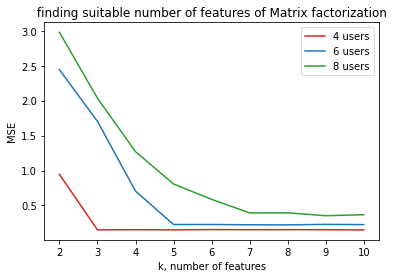

In [147]:
#ax1, ax2, ax3 = plt.subplots()

color = 'tab:red'
plt.xlabel('k, number of features')
plt.ylabel('MSE')
plt.plot(MSEtarget_listK, temp_resultLK4, color=color,label = '4 users')
#ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:blue'  
plt.plot(MSEtarget_listK, temp_resultLK6 , color=color,label = '6 users')
#plt.tick_params(axis='y', labelcolor=color)

color = 'tab:green'
plt.plot(MSEtarget_listK, temp_resultLK8 , color=color,label = '8 users')
#plt.tick_params(axis='y', labelcolor=color)

plt.title(" finding suitable number of features of Matrix factorization ")

plt.legend(['4 users', '6 users', '8 users'],
           loc='upper right',
           #bbox_to_anchor=[1.0,1.0],
           ncol=1,
           fontsize=10)

plt.show()

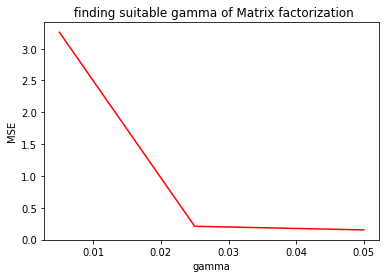

In [148]:
plt.plot(MSEtarget_listA,temp_resultLA4,c='r')
plt.xlabel( 'gamma' )
plt.ylabel( 'MSE' )
plt.title(" finding suitable gamma of Matrix factorization")
plt.show()

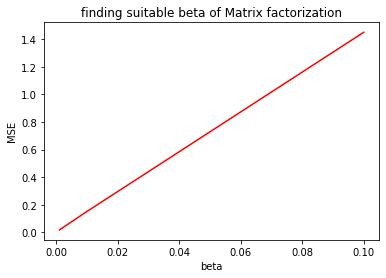

In [149]:
plt.plot(MSEtarget_listB,temp_resultLB4,c='r')
plt.xlabel( 'beta' )
plt.ylabel( 'MSE' )
plt.title("finding suitable beta of Matrix factorization")
plt.show()

In [ ]:
############################################################

In [285]:
case2.SetNPMPrice()

In [286]:
case2.ShowEnvSetting()

matrix of distance person to store : [[ 1.72981035  2.04617367  2.12968322 ... 56.88201366 56.43275402
  56.90096569]
 [ 1.61846161  1.63500627  1.70401655 ... 56.84020621 56.53176694
  56.86600163]
 [ 1.90520312  1.93794241  2.00474153 ... 57.13097785 56.79280698
  57.15566066]
 ...
 [ 1.56602383  1.76780011  1.84726298 ... 56.77888577 56.40001317
  56.80116037]
 [ 1.56602383  1.76780011  1.84726298 ... 56.77888577 56.40001317
  56.80116037]
 [ 1.56602383  1.76780011  1.84726298 ... 56.77888577 56.40001317
  56.80116037]]
matrix of tolerant distance-person : [5.  2.5 3.  2.  2.  3.  3.  3. ]
matrix of tolerant budget-person   : [[ 30  30  50 150  30]
 [ 30  30  30 150 150]
 [ 30  30  30  50  30]
 [ 30  50  50  50  50]
 [ 30  50  50  50  50]
 [ 50  50  50  50  50]
 [ 50  50  50  50  50]
 [ 50  50  50  50  50]]
matrix of acceptable cuisine   : [[1 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 0 1]
 [1 1 1

## model result and visualize

In [150]:
modelcase1 = Opt_model(case1)

In [151]:
model_c11 = modelcase1.FindRestaurant(0)
pyo.SolverFactory('cbc').solve(model_c11)

{'Problem': [{'Name': 'unknown', 'Lower bound': 84.14666679, 'Upper bound': 84.14666679, 'Number of objectives': 1, 'Number of constraints': 3527, 'Number of variables': 45090, 'Number of binary variables': 45090, 'Number of integer variables': 45090, 'Number of nonzeros': 45090, 'Sense': 'maximize'}], 'Solver': [{'Status': 'ok', 'User time': -1.0, 'System time': 3.61, 'Wallclock time': 3.76, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}, 'Black box': {'Number of iterations': 0}}, 'Error rc': 0, 'Time': 3.8365676403045654}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [152]:
Visual1 = VisualResult(model_c11,case1)

In [153]:
restaurantList = []
Visual1 = VisualResult(model_c11,case1)
Visual1.GetStoreList()
Visual1.ResultList

[180, 39, 7881, 1, 1148]

In [154]:
pd.DataFrame(case1.MData, index=Visual1.ResultList)

,name,bookings,rating,reviews,price,cuisine,location,dollars_price,latitude,longitude,user1,user2,user3,user4
180,Thai Ocean,NaN,NaN,NaN,2,Thai,Mid-Wilshire,<30,34.058441,-118.292137,NaN,NaN,NaN,5
39,Faith & Flower,NaN,4.6,Exceptional,2,Californian,Downtown,<30,34.046051,-118.261559,NaN,NaN,NaN,NaN
7881,Tum Thai Cuisine,NaN,NaN,NaN,2,Thai,Upland,<30,34.014736,-118.278772,NaN,NaN,NaN,NaN
1,HATCH Yakitori + Bar,34.0,4.5,Awesome,3,Japanese,Downtown,31-50,34.048075,-118.258141,NaN,NaN,NaN,5
1148,Bills Taco House,NaN,NaN,NaN,2,Mexican,Downtown,<30,34.011307,-118.270980,NaN,NaN,NaN,NaN


In [155]:
Visual1.RatingCalulate_show()

19.148633172313943
15.290534267420337
15.291112817717304
19.12590010422963
15.290486427510242
84.14666678919146


In [156]:
Visual1.distCalulate_show()

7.709985591327494
6.603244537773666
4.76620888912172
7.557064756482852
6.305477915852728
32.941981690558464


In [157]:
alpha_list00 = [0, 0.5,1.0,1.5,2.0]#[0, 0.05,0.1,0.15,0.2,0.25]#[0, 0.02,0.04,0.06,0.08,0.1]#
storeMatrix00 = []
list_rate00 = []
list_dist00 = []

for i in alpha_list00:
    model_c00 = modelcase1.FindRestaurant(i)
    pyo.SolverFactory('cbc').solve(model_c00)#model_c32 = FindRestaurant(Ttim3,Iper3,Kres3,rik3,dik30,Pk3,di,bit,i)
    #pyo.SolverFactory('cbc').solve(model_c32)
    Visual00 = VisualResult(model_c00,case1)
    Visual00.GetStoreList()
    storeList = Visual00.ResultList#GetStoreList(model_c00)
    storeMatrix00.append(storeList)
    list_rate00.append(Visual00.RatingCalulate())
    list_dist00.append(Visual00.distCalulate())

print(list_rate00)
print(list_dist00)

[84.14666678919146, 84.10988391253136, 76.38690842634692, 76.38690842634692, 76.38690842634692]
[32.941981690558464, 19.486052000345328, 8.420411805878658, 8.420411805878658, 8.420411805878658]


In [158]:
dfout00 = pd.DataFrame(case1.MData, index=storeMatrix00[0])
dfout04 = pd.DataFrame(case1.MData, index=storeMatrix00[4])

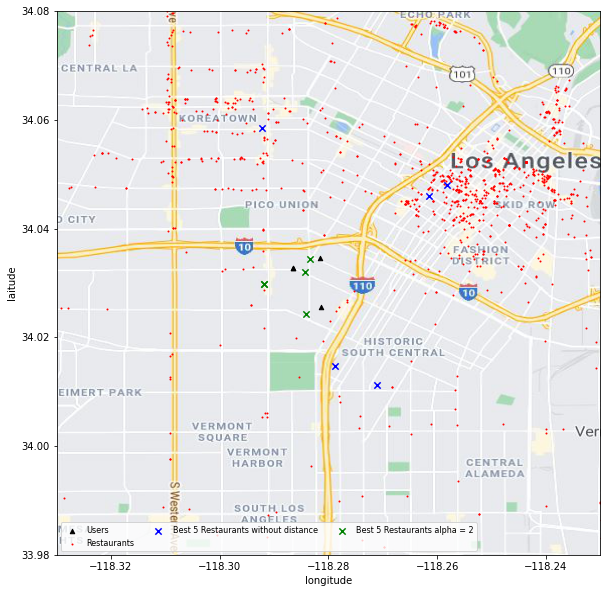

In [159]:
img01 = plt.imread("gdrive/My Drive/ISE533_21sp/PROJECT1/map_v4.JPG")


plt.figure(figsize=(10,10))
plt.imshow(img01, extent=[-118.33,-118.23,33.98,34.08])
person_point = [(person1.LocaI[1],person1.LocaI[0]),
                (person2.LocaI[1],person2.LocaI[0]),
                (person3.LocaI[1],person3.LocaI[0]),
                (person4.LocaI[1],person4.LocaI[0])]
dd = plt.scatter(*zip(*person_point), marker='^' , s=20,c='k')
d0 = plt.scatter(case1.MData["longitude"], case1.MData["latitude"], marker='o' , s=1, c='r')
d1 = plt.scatter(dfout00["longitude"], dfout00["latitude"], marker='x' , s=40, c='b')
d4 = plt.scatter(dfout04["longitude"], dfout04["latitude"], marker='x' , s=40, c='g')
plt.ylim(33.98,34.08)#(-22.813, -22.811)
plt.xlim(-118.33,-118.23)#(-43.251,-43.249)
plt.ticklabel_format(useOffset=False)
plt.legend((dd, d0,d1,d4),
           ('Users', 'Restaurants', 'Best 5 Restaurants without distance', 'Best 5 Restaurants alpha = 2'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)
plt.xlabel( 'longitude' )
plt.ylabel( 'laitude' )
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

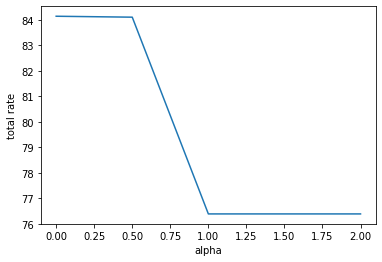

In [160]:
plt.plot(alpha_list00,list_rate00)
plt.xlabel( 'alpha' )
plt.ylabel( 'total rate' )
plt.show()

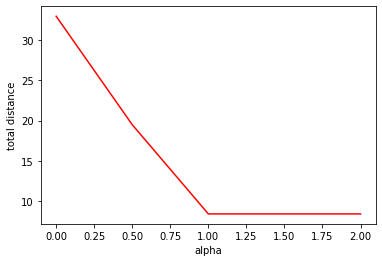

In [161]:
plt.plot(alpha_list00,list_dist00,c='r')
plt.xlabel( 'alpha' )
plt.ylabel( 'total distance' )
plt.show()

In [162]:
list_objc00 = []
for i in range(len(alpha_list00)):
    list_objc00.append(list_rate00[i] - alpha_list00[i] * list_dist00[i])
list_objc00

[84.14666678919146,
 74.3668579123587,
 67.96649662046826,
 63.756290717528934,
 59.546084814589605]

In [163]:
list(reversed(list_rate00))

[76.38690842634692,
 76.38690842634692,
 76.38690842634692,
 84.10988391253136,
 84.14666678919146]

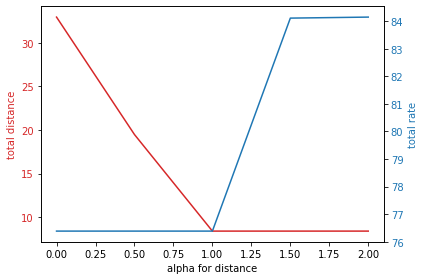

In [164]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('alpha for distance')
ax1.set_ylabel('total distance', color=color)
ax1.plot(alpha_list00, list_dist00, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('total rate', color=color)  # we already handled the x-label with ax1
ax2.set_xlabel('alpha for rating')    
ax2.xaxis.set_label_position('top') 
ax2.plot(alpha_list00, list(reversed(list_rate00)) , color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [165]:
model_ff = modelcase1.FindRestaurant(1.0)
pyo.SolverFactory('cbc').solve(model_ff)

{'Problem': [{'Name': 'unknown', 'Lower bound': 67.96649662, 'Upper bound': 67.96649662, 'Number of objectives': 1, 'Number of constraints': 3527, 'Number of variables': 45090, 'Number of binary variables': 45090, 'Number of integer variables': 45090, 'Number of nonzeros': 45090, 'Sense': 'maximize'}], 'Solver': [{'Status': 'ok', 'User time': -1.0, 'System time': 3.64, 'Wallclock time': 3.77, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}, 'Black box': {'Number of iterations': 0}}, 'Error rc': 0, 'Time': 3.8197507858276367}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [166]:
Visualff = VisualResult(model_ff,case1)

In [167]:
restaurantList = []
Visualff = VisualResult(model_ff,case1)
Visualff.GetStoreList()
Visualff.ResultList

[7736, 850, 733, 788, 14]

In [168]:
pd.DataFrame(case1.MData, index=Visualff.ResultList)

,name,bookings,rating,reviews,price,cuisine,location,dollars_price,latitude,longitude,user1,user2,user3,user4
7736,Empire Restaurant & Catering Group,NaN,NaN,NaN,2,American,Montclair,<30,34.029781,-118.291775,NaN,NaN,NaN,NaN
850,Rock & Reilly's USC,NaN,4.4,Awesome,2,Pub,Downtown,<30,34.024234,-118.284092,NaN,NaN,NaN,NaN
733,Elemental,NaN,NaN,NaN,2,American,Downtown,<30,34.032091,-118.284349,NaN,NaN,NaN,NaN
788,Valentina Mexican Grill,NaN,NaN,NaN,2,Mexican,Downtown,<30,34.029728,-118.291808,NaN,NaN,NaN,NaN
14,Bacari Adams,66.0,4.6,Exceptional,2,Tapas / Small Plates,Downtown,<30,34.034504,-118.283461,NaN,NaN,NaN,NaN


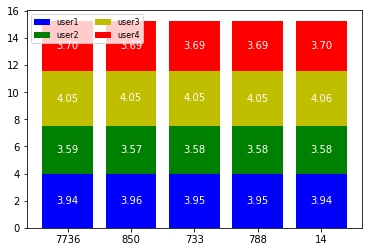

In [169]:
labels1 = [str(x) for x in Visualff.ResultList]
#labels1 = Visualff.ResultList
xru1,xru2,xru3,xru4 = Visualff.rateIndivid()
fig,ax = plt.subplots()

ax1 = ax.bar(labels1,xru1, label = 'user1', color = 'b')
ax2 = ax.bar(labels1,xru2, bottom= xru1,label = 'user2', color = 'g')
ax3 = ax.bar(labels1,xru3, bottom= np.array(xru1)+np.array(xru2),label = 'user3', color = 'y')
ax4 = ax.bar(labels1,xru4, bottom= np.array(xru1)+np.array(xru2)+np.array(xru3),label = 'user4', color = 'r')

for r1,r2,r3,r4 in zip(ax1,ax2,ax3,ax4):
    h1 = r1.get_height()
    h2 = r2.get_height()
    h3 = r3.get_height()
    h4 = r4.get_height()
    plt.text(r1.get_x() + r1.get_width()/2. , h1/2. , "%.02f" % h1, ha = "center", va = "center", color = "white" )
    plt.text(r2.get_x() + r2.get_width()/2. , h1 + h2/2. , "%.02f" % h2, ha = "center", va = "center", color = "white" )
    plt.text(r3.get_x() + r3.get_width()/2. , h1 + h2 + h3/2. , "%.02f" % h3, ha = "center", va = "center", color = "white" )
    plt.text(r4.get_x() + r4.get_width()/2. , h1 + h2 + h3 + h4/2. , "%.02f" % h4, ha = "center", va = "center", color = "white" )

plt.legend(['user1', 'user2', 'user3', 'user4'],
           loc='upper left',
           ncol=2,
           fontsize=8)

plt.show()

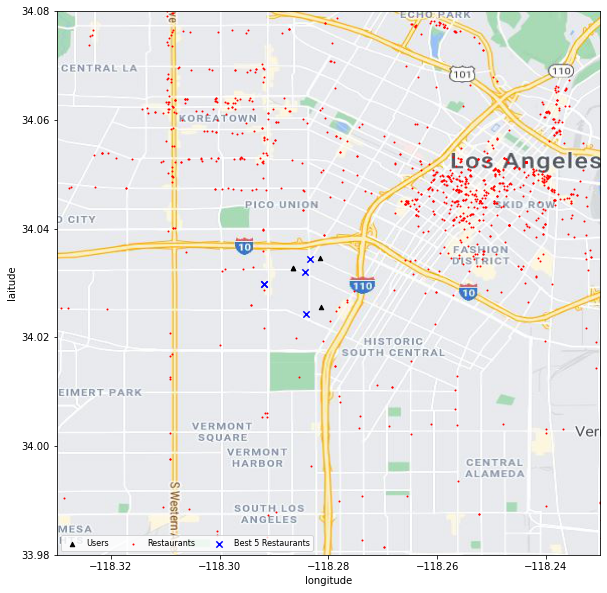

In [170]:
dfout05 = pd.DataFrame(case1.MData, index=Visualff.ResultList)

plt.figure(figsize=(10,10))
plt.imshow(img01, extent=[-118.33,-118.23,33.98,34.08])
person_point = [(person1.LocaI[1],person1.LocaI[0]),
                (person2.LocaI[1],person2.LocaI[0]),
                (person3.LocaI[1],person3.LocaI[0]),
                (person4.LocaI[1],person4.LocaI[0])]
dd = plt.scatter(*zip(*person_point), marker='^' , s=20,c='k')
d0 = plt.scatter(case1.MData["longitude"], case1.MData["latitude"], marker='o' , s=1, c='r')
d1 = plt.scatter(dfout05["longitude"], dfout05["latitude"], marker='x' , s=40, c='b')
plt.ylim(33.98,34.08)#(-22.813, -22.811)
plt.xlim(-118.33,-118.23)#(-43.251,-43.249)
plt.ticklabel_format(useOffset=False)
plt.legend((dd, d0,d1),
           ('Users', 'Restaurants', 'Best 5 Restaurants'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)
plt.xlabel( 'longitude' )
plt.ylabel( 'laitude' )
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
############################################################################################################

In [ ]:
#modelcaseextend1 = Opt_model_2(case1)

In [171]:
modelcase1.CuisineRestric()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [172]:
modelcase1.Lextra#np.array(modelcaseextend1.Lextra)

,cuisine_American,cuisine_Chinese,cuisine_Contemporary American,cuisine_Italian,cuisine_Japanese,cuisine_Mexican,cuisine_Seafood,cuisine_Sushi,cuisine_Thai,cuisine_other
0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
9013,0,0,0,0,0,0,0,0,0,1
9014,0,0,0,0,0,1,0,0,0,0
9015,1,0,0,0,0,0,0,0,0,0
9016,0,0,0,0,0,0,0,0,0,1


In [173]:
model_ext1 = modelcase1.FindRestaurant_v2(1.0)
pyo.SolverFactory('cbc').solve(model_ext1)

{'Problem': [{'Name': 'unknown', 'Lower bound': 67.67015891, 'Upper bound': 67.67015891, 'Number of objectives': 1, 'Number of constraints': 3537, 'Number of variables': 45090, 'Number of binary variables': 45090, 'Number of integer variables': 45090, 'Number of nonzeros': 45090, 'Sense': 'maximize'}], 'Solver': [{'Status': 'ok', 'User time': -1.0, 'System time': 6.1, 'Wallclock time': 6.34, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}, 'Black box': {'Number of iterations': 0}}, 'Error rc': 0, 'Time': 6.412706136703491}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [174]:
Visualext1 = VisualResult(model_ext1,case1)
Visualext1.GetStoreList()
Visualext1.ResultList

[824, 788, 14, 857, 733]

In [175]:
pd.DataFrame(case1.MData, index=Visualext1.ResultList)

,name,bookings,rating,reviews,price,cuisine,location,dollars_price,latitude,longitude,user1,user2,user3,user4
824,Pasta Roma,NaN,NaN,NaN,2,Italian,Downtown,<30,34.025649,-118.278040,NaN,NaN,NaN,NaN
788,Valentina Mexican Grill,NaN,NaN,NaN,2,Mexican,Downtown,<30,34.029728,-118.291808,NaN,NaN,NaN,NaN
14,Bacari Adams,66.0,4.6,Exceptional,2,Tapas / Small Plates,Downtown,<30,34.034504,-118.283461,NaN,NaN,NaN,NaN
857,Trio House,NaN,NaN,NaN,2,Thai,Downtown,<30,34.026917,-118.276579,NaN,NaN,NaN,NaN
733,Elemental,NaN,NaN,NaN,2,American,Downtown,<30,34.032091,-118.284349,NaN,NaN,NaN,NaN


In [176]:
model_ext2 = modelcase1.FindRestaurant_v3(1.0)
pyo.SolverFactory('cbc').solve(model_ext2)

{'Problem': [{'Name': 'unknown', 'Lower bound': 66.46445255, 'Upper bound': 66.46445255, 'Number of objectives': 1, 'Number of constraints': 2491, 'Number of variables': 32820, 'Number of binary variables': 45090, 'Number of integer variables': 45090, 'Number of nonzeros': 32820, 'Sense': 'maximize'}], 'Solver': [{'Status': 'ok', 'User time': -1.0, 'System time': 6.2, 'Wallclock time': 6.5, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}, 'Black box': {'Number of iterations': 0}}, 'Error rc': 0, 'Time': 6.56224799156189}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [177]:
Visualext2 = VisualResult(model_ext2,case1)
Visualext2.GetStoreList()
Visualext2.ResultList

[733, 824, 857, 788, 1544]

In [178]:
pd.DataFrame(case1.MData, index=Visualext2.ResultList)

,name,bookings,rating,reviews,price,cuisine,location,dollars_price,latitude,longitude,user1,user2,user3,user4
733,Elemental,NaN,NaN,NaN,2,American,Downtown,<30,34.032091,-118.284349,NaN,NaN,NaN,NaN
824,Pasta Roma,NaN,NaN,NaN,2,Italian,Downtown,<30,34.025649,-118.278040,NaN,NaN,NaN,NaN
857,Trio House,NaN,NaN,NaN,2,Thai,Downtown,<30,34.026917,-118.276579,NaN,NaN,NaN,NaN
788,Valentina Mexican Grill,NaN,NaN,NaN,2,Mexican,Downtown,<30,34.029728,-118.291808,NaN,NaN,NaN,NaN
1544,California Sushi & Teriyaki,NaN,NaN,NaN,2,Sushi,Beverly / Fairfax / La Brea / Third St.,<30,34.028566,-118.275235,NaN,NaN,NaN,NaN


In [ ]:
alpha_list01 =  [0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5]#[0.75, 0.8,0.85,0.9,0.95,1.0,1.05,1.1,1.15,1.2,1.25]#[0, 0.05,0.1,0.15,0.2,0.25]#[0, 0.02,0.04,0.06,0.08,0.1]#
storeMatrix01 = []
list_rate01 = []
list_dist01 = []

for i in alpha_list01:
    model_c01 = modelcase1.FindRestaurant(i)
    pyo.SolverFactory('cbc').solve(model_c01)#model_c32 = FindRestaurant(Ttim3,Iper3,Kres3,rik3,dik30,Pk3,di,bit,i)
    #pyo.SolverFactory('cbc').solve(model_c32)
    Visual01 = VisualResult(model_c01,case1)
    Visual01.GetStoreList()
    storeList = Visual01.ResultList#GetStoreList(model_c00)
    storeMatrix01.append(storeList)
    list_rate01.append(Visual01.RatingCalulate())
    list_dist01.append(Visual01.distCalulate())

print(list_rate01)
print(list_dist01)

[83.75258519761796, 83.74678905508298, 76.3694086731715, 76.3694086731715, 76.36940867317149, 76.36940867317149, 76.36940867317149, 76.36940867317149, 76.36940867317149, 76.36940867317149, 76.36940867317149]
[19.49683720441138, 19.48605200034533, 8.420411805878658, 8.420411805878658, 8.420411805878658, 8.420411805878658, 8.420411805878658, 8.420411805878658, 8.420411805878658, 8.420411805878658, 8.420411805878658]


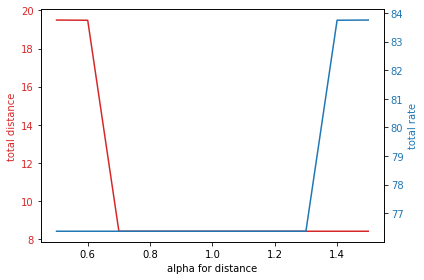

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('alpha for distance')
ax1.set_ylabel('total distance', color=color)
ax1.plot(alpha_list01, list_dist01, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('total rate', color=color)  # we already handled the x-label with ax1
ax2.set_xlabel('alpha for rating')    
ax2.xaxis.set_label_position('top') 
ax2.plot(alpha_list01, list(reversed(list_rate01)) , color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
########################################################################